In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import joblib
import geemap

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from shapely.geometry import Point, Polygon



In [2]:
# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='svevazanettieo1') #così apro il progetto esistente in GEE, non ne sto creando uno nuovo

In [4]:
scaler = joblib.load("scaler.save")
clf = joblib.load("random_forest_model_train+val.pkl")

In [5]:
# Function to convert Earth Engine FeatureCollection to Pandas DataFrame, eliminating the random column
def from_FeatureCollection_to_df(path):
    points = ee.FeatureCollection(path)
    points_ft = points.getInfo()['features']
    points_df = pd.json_normalize(points_ft)
    points_df = points_df.drop(columns=['properties.random'], errors='ignore')
    return points_df

testing_points_df_2018 = from_FeatureCollection_to_df('projects/svevazanettieo1/assets/Dubai/Dubai_testing_indexes')
testing_points_df_2024 = from_FeatureCollection_to_df('projects/svevazanettieo1/assets/Dubai/Dubai_testing_indexes_2024')

print('Testing set 2018:', testing_points_df_2018.shape)
print('Testing set 2024:', testing_points_df_2024.shape)

Testing set 2018: (399, 14)
Testing set 2024: (297, 14)


In [6]:
# Extract feature columns (e.g., 'properties.B1', 'properties.B2', etc.)
feature_columns = [col for col in testing_points_df_2018.columns if col.startswith('properties.B') or col.startswith('properties.n')]
feature_columns

# Extract features and labels for testing
X_test_2018 = testing_points_df_2018[feature_columns]
y_test_2018 = testing_points_df_2018['properties.LC']

X_test_2024 = testing_points_df_2024[feature_columns]
y_test_2024 = testing_points_df_2024['properties.LC']

In [7]:
X_test_2018 = scaler.transform(X_test_2018)
X_test_2024 = scaler.transform(X_test_2024)

# Testing 2018

In [8]:
X_shuffled_test_2018, y_shuffled_test_2018, testing_points_df_2018 = shuffle(X_test_2018, y_test_2018, testing_points_df_2018, random_state=42)

# Predicting using the model
y_pred_test_2018 = clf.predict(X_shuffled_test_2018)  # Get predictions from the model

In [17]:
from sklearn.metrics import accuracy_score

In [19]:
val_accuracy_2018 = accuracy_score(y_shuffled_test_2018, y_pred_test_2018)
val_accuracy_2018

1.0

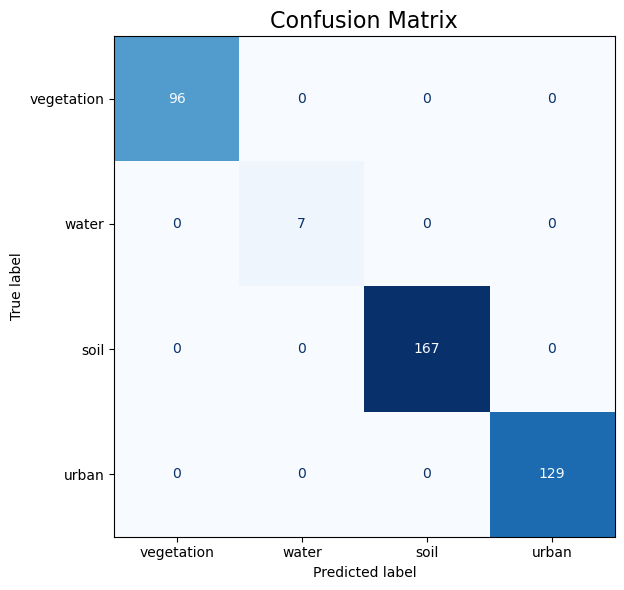

In [9]:
# Compute confusion matrix
cm_2018 = confusion_matrix(y_shuffled_test_2018, y_pred_test_2018)

# Plot
fig, ax = plt.subplots(figsize=(8, 6)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2018, display_labels=['vegetation','water','soil','urban'])
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)  # use ax
ax.set_title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
testing_points_df_2018['predicted'] = y_pred_test_2018

def make_geometry(row):
    if row['geometry.type'] == 'Point':
        return Point(row['geometry.coordinates'])
    elif row['geometry.type'] == 'Polygon':
        return Polygon(row['geometry.coordinates'])
    else:
        return None  # o gestisci altri tipi se ci sono

testing_points_df_2018['geometry'] = testing_points_df_2018.apply(make_geometry, axis=1)
gdf_2018 = gpd.GeoDataFrame(testing_points_df_2018, geometry='geometry')
gdf_2018.set_crs(epsg=4326, inplace=True)

,type,id,geometry.type,geometry.coordinates,properties.B11,properties.B12,properties.B2,properties.B3,properties.B4,properties.B8,properties.LC,properties.ndbi,properties.ndvi,properties.ndwi,predicted,geometry
198,Feature,000000000000000000c6,Point,"[55.54970620160949, 25.276842395159093]",0.48945,0.42685,0.1639,0.2362,0.30050,0.40140,2,0.096905,0.144922,-0.258661,2,POINT (55.54971 25.27684)
349,Feature,0000000000000000015d,Point,"[55.58150851032266, 25.239381487209098]",0.37330,0.32270,0.1271,0.1790,0.23180,0.25000,3,0.185936,0.038700,-0.164948,3,POINT (55.58151 25.23938)
33,Feature,00000000000000000021,Point,"[55.5377602698873, 25.275312923497765]",0.25640,0.14550,0.0389,0.0792,0.04820,0.36690,0,-0.182350,0.767902,-0.644713,0,POINT (55.53776 25.27531)
208,Feature,000000000000000000d0,Point,"[55.548448735112416, 25.277738674470832]",0.50620,0.44960,0.1889,0.2710,0.34100,0.41820,2,0.093586,0.101741,-0.213660,2,POINT (55.54845 25.27774)
93,Feature,0000000000000000005d,Point,"[55.53865654919904, 25.27926368703111]",0.28415,0.16055,0.0457,0.0939,0.06025,0.41270,0,-0.176435,0.745587,-0.628727,0,POINT (55.53866 25.27926)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Feature,00000000000000000047,Point,"[55.524463230545926, 25.276392025952692]",0.31865,0.18805,0.0618,0.1052,0.08945,0.31900,0,0.000393,0.573840,-0.517528,0,POINT (55.52446 25.27639)
106,Feature,0000000000000000006a,Point,"[55.58653837631094, 25.227792283571194]",0.61900,0.54655,0.1966,0.2945,0.40300,0.46820,2,0.136824,0.074901,-0.227768,2,POINT (55.58654 25.22779)
270,Feature,0000000000000000010e,Point,"[55.55922638235859, 25.23183668822666]",0.48295,0.43695,0.4928,0.5660,0.58815,0.57960,3,-0.096617,-0.017375,-0.002482,3,POINT (55.55923 25.23184)
348,Feature,0000000000000000015c,Point,"[55.581414869200536, 25.239203123166956]",0.39320,0.34305,0.1529,0.2135,0.26350,0.28540,3,0.155626,0.033027,-0.143845,3,POINT (55.58141 25.2392)


In [11]:
sentinel2018 = ee.Image('projects/svevazanettieo1/assets/Dubai/sentinel2018')
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 0.3,
}

# Select only the necessary columns for visualization
test_points_RF = geemap.geopandas_to_ee(gdf_2018[['predicted', 'geometry']])

# Convert FeatureCollection to Image
test_image = test_points_RF.reduceToImage(properties=['predicted'], reducer=ee.Reducer.first())

# Increase point size using focal_max()
test_image = test_image.focal_max(radius=30, units='meters')

vis = {
  'min': 0,
  'max': 3,
  'palette': ['00FF00', '00FFFF', 'FFFF00', 'FF0000'] 
}

# AOI boundary
AOI = ee.FeatureCollection('projects/svevazanettieo1/assets/Dubai/Area_of_interest_Dubai')

# Create a map centered on AOI
Map = geemap.Map(center=[25.25919846235865, 55.56474292797696], zoom=13)
Map.addLayer(AOI, {'color': 'gray'}, 'AOI')
Map.addLayer(sentinel2018, vis_params, 'Sentinel-2 2018')

# Add the predictor layers
Map.addLayer(test_image, vis,'Prediction')
Map

Map(center=[25.25919846235865, 55.56474292797696], controls=(WidgetControl(options=['position', 'transparent_b…

# Testing 2024

In [12]:
X_shuffled_test_2024, y_shuffled_test_2024, testing_points_df_2024 = shuffle(X_test_2024, y_test_2024, testing_points_df_2024, random_state=42)

# Predicting using the model
y_pred_test_2024 = clf.predict(X_shuffled_test_2024)  # Get predictions from the model

In [20]:
val_accuracy_2024 = accuracy_score(y_shuffled_test_2024, y_pred_test_2024)
val_accuracy_2024

0.9797979797979798

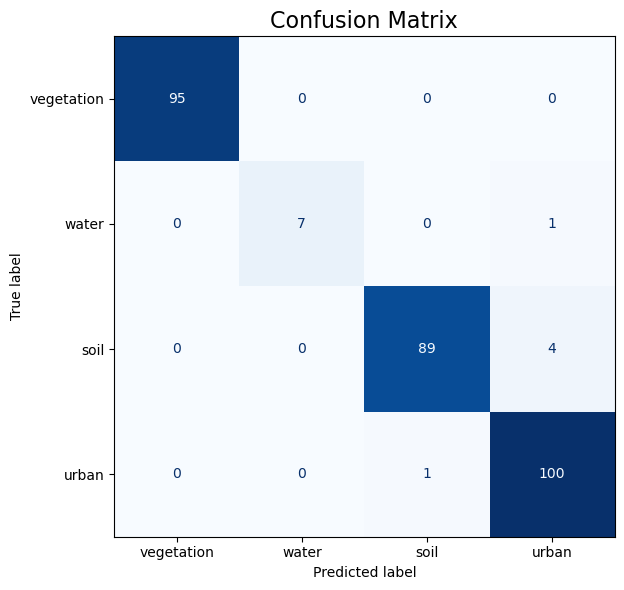

In [13]:
# Compute confusion matrix
cm_2024 = confusion_matrix(y_shuffled_test_2024, y_pred_test_2024)

# Plot
fig, ax = plt.subplots(figsize=(8, 6)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2024, display_labels=['vegetation','water','soil','urban'])
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)  # use ax
ax.set_title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
testing_points_df_2024['predicted'] = y_pred_test_2024

testing_points_df_2024['geometry'] = testing_points_df_2024.apply(make_geometry, axis=1)
gdf_2024 = gpd.GeoDataFrame(testing_points_df_2024, geometry='geometry')
gdf_2024.set_crs(epsg=4326, inplace=True)

,type,id,geometry.type,geometry.coordinates,properties.B11,properties.B12,properties.B2,properties.B3,properties.B4,properties.B8,properties.LC,properties.ndbi,properties.ndvi,properties.ndwi,predicted,geometry
167,Feature,000000000000000000a7,Point,"[55.60127124619153, 25.278006220534042]",0.4456,0.4026,0.1284,0.1854,0.2532,0.3184,2,0.162999,0.116213,-0.264516,2,POINT (55.60127 25.27801)
211,Feature,000000000000000000d3,Point,"[55.592107793526694, 25.24297552265817]",0.3088,0.2675,0.2542,0.2956,0.3452,0.3284,3,0.015263,-0.002273,-0.017768,3,POINT (55.59211 25.24298)
63,Feature,0000000000000000003f,Point,"[55.56596408405035, 25.274416644186022]",0.2772,0.1669,0.0603,0.1158,0.0890,0.4432,0,-0.226131,0.671233,-0.589670,0,POINT (55.56596 25.27442)
154,Feature,0000000000000000009a,Point,"[55.57863239014318, 25.277377487285506]",0.5325,0.5050,0.1738,0.2604,0.3480,0.4204,2,0.117927,0.087866,-0.230589,2,POINT (55.57863 25.27738)
5,Feature,00000000000000000005,Point,"[55.57252342169997, 25.240188584499766]",0.2723,0.1464,0.0469,0.0974,0.0615,0.4832,0,-0.288118,0.773913,-0.666905,0,POINT (55.57252 25.24019)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Feature,000000000000000000bc,Point,"[55.530211011803814, 25.28276854045912]",0.4847,0.4551,0.1626,0.2302,0.3032,0.3556,2,0.151912,0.085188,-0.217449,2,POINT (55.53021 25.28277)
71,Feature,00000000000000000047,Point,"[55.52257703080031, 25.274773372270293]",0.3005,0.1866,0.0604,0.1026,0.1027,0.3585,0,-0.083981,0.552106,-0.556036,0,POINT (55.52258 25.27477)
106,Feature,0000000000000000006a,Point,"[55.55761218777724, 25.261480792029975]",0.5057,0.4817,0.1832,0.2708,0.3688,0.4328,2,0.078221,0.083036,-0.230174,2,POINT (55.55761 25.26148)
270,Feature,0000000000000000010e,Point,"[55.533715865231834, 25.242703517493915]",0.2876,0.2484,0.1302,0.1656,0.1910,0.2287,3,0.101613,0.088788,-0.165323,3,POINT (55.53372 25.2427)


In [15]:
sentinel2024 = ee.Image('projects/svevazanettieo1/assets/Dubai/sentinel2024')
# Select only the necessary columns for visualization
test_points_RF = geemap.geopandas_to_ee(gdf_2024[['predicted', 'geometry']])

# Convert FeatureCollection to Image
test_image = test_points_RF.reduceToImage(properties=['predicted'], reducer=ee.Reducer.first())

# Increase point size using focal_max()
test_image = test_image.focal_max(radius=30, units='meters')

# Create a map centered on AOI
Map = geemap.Map(center=[25.25919846235865, 55.56474292797696], zoom=13)
Map.addLayer(AOI, {'color': 'gray'}, 'AOI')
Map.addLayer(sentinel2024, vis_params, 'Sentinel-2 2024')

# Add the predictor layers
Map.addLayer(test_image, vis,'Prediction')
Map

Map(center=[25.25919846235865, 55.56474292797696], controls=(WidgetControl(options=['position', 'transparent_b…

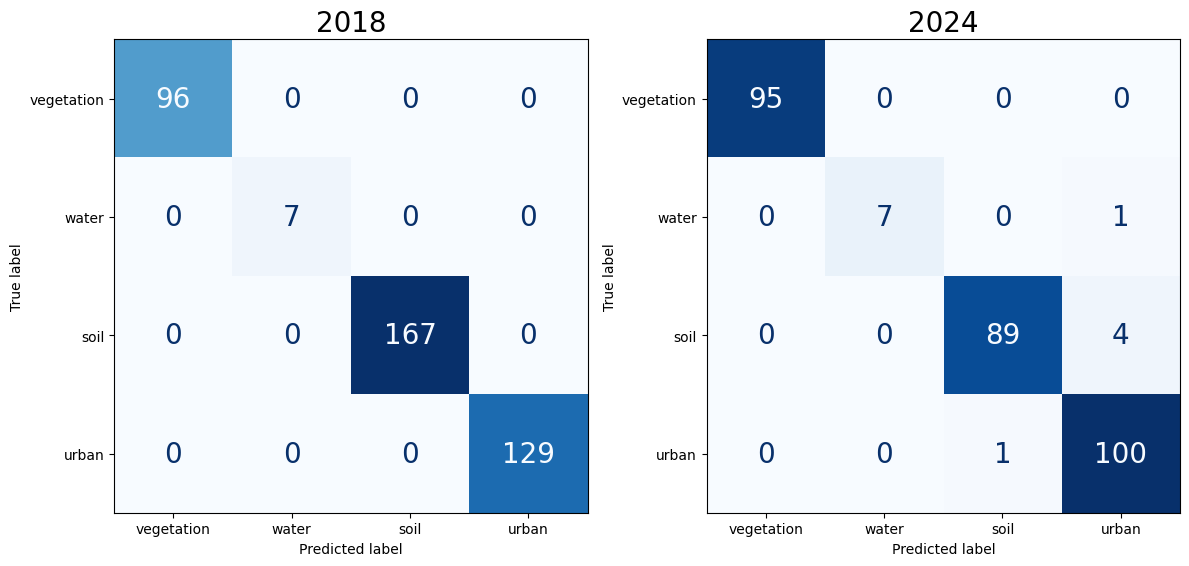

In [22]:
cm1 = cm_2018
cm2 = cm_2024

cms = [cm_2018, cm_2024]
titles = ['2018', '2024']
fig, axes = plt.subplots(1, 2, figsize=(12, 10)) 

for i, ax in enumerate(axes.flatten()):
    disp = ConfusionMatrixDisplay(confusion_matrix=cms[i], display_labels=['vegetation','water','soil','urban'])
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False, text_kw={"fontsize":20})  # use ax
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()
plt.show()